In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:
%config Completer.use_jedi = False

In [3]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.population_simulation import PopulationSimulation
import pandas as pd
from functools import partial
import yaml

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 144 results
transitions_data returned 17 results
total_population_data returned 144 results
initialization time:  36.738723039627075
simulation_time:  27.20028305053711
initialization time:  40.18661689758301
simulation_time:  28.531716108322144
initialization time:  37.753430128097534
simulation_time:  27.735281944274902


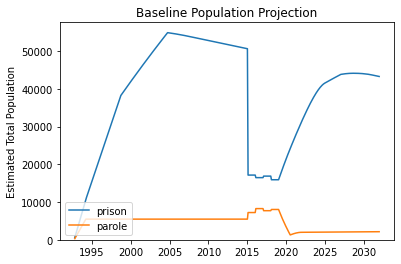

In [23]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/MS/SB 2123 - Parole Eligibility/MS_prison_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
test_sim.simulate_baseline(['prison', 'parole'])

,parole,prison,sub-group
0,1.492154,0.597240,nonviolent
-1,1.255818,0.685811,nonviolent
-2,2.132091,0.631009,nonviolent
-3,1.894492,0.418168,nonviolent
-28,NaN,NaN,nonviolent
...,...,...,...
8,NaN,NaN,violent
9,NaN,NaN,violent
10,NaN,NaN,violent
11,NaN,NaN,violent


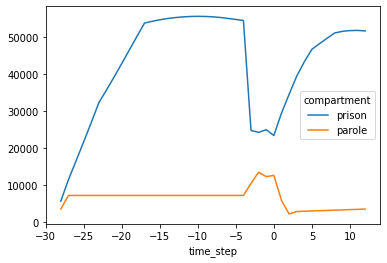

In [39]:
# need to have run baseline for this to work: checking the scale factors are decently close to 1 and population projections look reasonable
test_sim.pop_simulations['baseline'].population_projections.groupby(['time_step', 'compartment']).total_population.sum().unstack()[['prison','parole']].plot()
test_sim.pop_simulations['baseline'].gen_scale_factors_df()

initialization time:  41.676252126693726
simulation_time:  31.853859663009644
initialization time:  41.95944118499756
simulation_time:  31.007224798202515


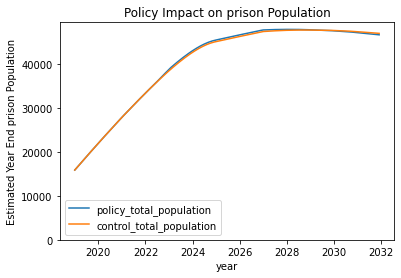

In [29]:
# Policy Option Methods
# current_eligibility = {'nonviolent': 0.25, 'violent': 1}
policy_eligibility = {'nonviolent': 0.35, 'violent': 0.5}
full_sentence = {'nonviolent': 6 * 12, 'violent': 12 * 12}
GRANT_RATE = 0.1

test_sim.data_dict['transitions_data'].loc[(test_sim.data_dict['transitions_data'].compartment=='prison') &
                                           (test_sim.data_dict['transitions_data'].outflow_to=='parole') & 
                                           (test_sim.data_dict['transitions_data'].crime_type=='nonviolent'), 
                                           'total_population'] = GRANT_RATE
test_sim.data_dict['transitions_data'].loc[(test_sim.data_dict['transitions_data'].compartment=='prison') &
                                           (test_sim.data_dict['transitions_data'].outflow_to=='release') & 
                                           (test_sim.data_dict['transitions_data'].crime_type=='nonviolent'), 
                                           'total_population'] = 1 - GRANT_RATE

policy_transitions = {
    crime_type : pd.DataFrame({
        'compartment': ['prison'] * 2, 
        'outflow_to': ['release', 'parole'], 
        'total_population': [1 - GRANT_RATE, GRANT_RATE], 
        'compartment_duration': [full_sentence[crime_type], full_sentence[crime_type] * policy_eligibility[crime_type]],
        'crime_type': [crime_type] * 2})
    for crime_type in policy_eligibility
}


def apply_disposition_change(crime_type, retroactive=False):
    return partial(CompartmentTransitions.use_alternate_transitions_data, 
                   alternate_historical_transitions=policy_transitions[crime_type],
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_disposition_change(crime_type),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                apply_retroactive=False)
    for crime_type in policy_eligibility
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [20]:
#peeking at the transition tables to make sure they're transformed the way I expect them to be
pd.options.display.max_rows = 999
test_sim.pop_simulations['policy'].sub_simulations['violent'].simulation_compartments['prison'].transition_tables.transition_dfs

{'before': outflow_to            release  remaining
 compartment_duration                    
 1                         0.0        1.0
 2                         0.0        1.0
 3                         0.0        1.0
 4                         0.0        1.0
 5                         0.0        1.0
 6                         0.0        1.0
 7                         0.0        1.0
 8                         0.0        1.0
 9                         0.0        1.0
 10                        0.0        1.0
 11                        0.0        1.0
 12                        0.0        1.0
 13                        0.0        1.0
 14                        0.0        1.0
 15                        0.0        1.0
 16                        0.0        1.0
 17                        0.0        1.0
 18                        0.0        1.0
 19                        0.0        1.0
 20                        0.0        1.0
 21                        0.0        1.0
 22                     

In [30]:
simulation_tag = 'MS_SB_2123_10%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [21]:
test_sim.output_data['life_years']

,parole,release,revocations,prison
year,,,,
2019,0.0,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0
2023,0.0,0.0,0.0,0.0
2024,0.0,0.0,0.0,0.0
2025,0.0,0.0,0.0,0.0
2026,0.0,0.0,0.0,0.0
2027,0.0,0.0,0.0,0.0


In [6]:
test_sim.output_data['life_years']

,prison_new_offense,release,prison_technical,probation
year,,,,
2019.000000,-0.002094,-0.299183,-0.003625,0.304998
2019.083333,-0.004179,-0.599141,-0.007241,0.610753
2019.166667,-0.006255,-0.899844,-0.010847,0.917236
2019.250000,-0.008325,-1.201261,-0.014444,1.224417
2019.333333,-0.010387,-1.503358,-0.018029,1.532259
...,...,...,...,...
2028.583333,-13.124750,-17007.892523,842.607207,16178.421918
2028.666667,-12.814180,-17358.118949,855.795426,16515.149657
2028.750000,-12.491085,-17710.831560,868.914107,16854.420595


In [8]:
test_sim.pop_simulations['control'].sub_simulations['x'].simulation_compartments['prison_parole_revocations'].transition_tables.transition_dfs

{'before':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'transitory':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'after_retroactive':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.